Попробуем делать это следующим образом:
<ol> План работы
<li> Регрессор по тем же параметрам, что использовал в третьей неделе.
<li> Предсказания на 6 часов вперёд по SARIMAX
<li> Решающий лес
</ol>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing, linear_model, model_selection
from sklearn.tree import DecisionTreeRegressor as DTR
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [2]:
def processDataFrame(inpDf, Kw = 7, Ka = 2):
    """
    Обрабатываем сразу весь dateFrame и добавляем признаки, общие для всех рядов
    тренд, гармоники, категориальные перемнные
    для дат, дней недели, etc)

    Parameters:
    Kw number of weeks harmonics
    Ka number of annual harmonics
    """   
    inpDf = inpDf.assign(linear = (inpDf.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # час — эти признаки можно пробовать брать и категориальными
    # и непрерывными, можно даже и так, и так

    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        inpDf['weekCos'+str(ind)]= np.cos(np.pi*inpDf.linear*ind/168)
        inpDf['weekSin'+str(ind)]= np.sin(np.pi*inpDf.linear*ind/168)
     
    for ind in range(1,Ka+1):
        inpDf['yearCos'+str(ind)]= np.cos(2*np.pi*inpDf.linear*ind/8766)        
        inpDf['yearSin'+str(ind)]= np.sin(2*np.pi*inpDf.linear*ind/8766)

    # добавляем числовое и категориальные свойства для дней недели
    inpDf = inpDf.assign(dayOfWeek = inpDf.index.dayofweek)
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(inpDf.index.dayofweek),columns = ['dayOfWeek_'+str(x) for x in np.arange(6)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(DoW,left_index=True,right_index=True)

    # добавляем dummy variables для месяца
    inpDf = inpDf.assign(month = inpDf.index.month)
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(inpDf.index.month),columns = ['month_'+str(x) for x in np.arange(1,13)],
                          index = inpDf.index)      
    inpDf = inpDf.merge(Months,left_index=True,right_index=True);

    # добавляем год (вещественный)
    inpDf = inpDf.assign(year = inpDf.index.year)

    # добавляем день месяца (вещественный)
    inpDf = inpDf.assign(day = inpDf.index.day)

    # добавляем час (вещественный и категориальный)
    inpDf = inpDf.assign(hour = inpDf.index.hour)
    lbHours = preprocessing.LabelBinarizer()
    lbHours.fit(list(np.arange(24)))
    Hours = pd.DataFrame(lbHours.transform(inpDf.index.hour),columns = ['hour_'+str(x) for x in np.arange(24)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(Hours,left_index=True,right_index=True)
    
    return inpDf

In [11]:
def saveFile(df_inp,fName = 'w5.csv'):
    f = open(fName,'w')
    f.writelines('id,y\n')
    
    
    
    df = df_inp.reset_index()
    df.rename(columns={'index':'date'},inplace=True)

    for ind, row in df.iterrows():
        historyStart = row.date

        if historyStart > datetime.datetime(2016,6,30,17):
            continue

        s0 = str(row.region)+'_'+ str(datetime.datetime.strftime(historyStart, "%Y-%m-%d"))+ '_'+ str(historyStart.hour)

        s1 = s0 +'_1,'+str(rnd(row.get('y1'))) + '\n'
        f.writelines(s1)

        s2 = s0 +'_2,'+str(rnd(row.get('y2'))) + '\n'
        f.writelines(s2)

        s3 = s0 +'_3,'+str(rnd(row.get('y3'))) + '\n'
        f.writelines(s3)

        s4 = s0 +'_4,'+str(rnd(row.get('y4'))) + '\n'
        f.writelines(s4)

        s5 = s0 +'_5,'+str(rnd(row.get('y5'))) + '\n'
        f.writelines(s5)

        s6 = s0 +'_6,'+str(rnd(row.get('y6'))) + '\n'
        f.writelines(s6)

    f.close()    
    
def rnd(x):
    return int(np.round(x))

In [3]:
# define time frames
startTrain = '2014-01-01 00:00:00'
endTrain   = '2016-04-30 23:00:00'

startValidation = '2016-05-01 00:00:00'
endValidation   = '2016-05-31 23:00:00'

startTest = '2016-06-01 00:00:00'
endTest   = '2016-06-30 23:00:00'

In [4]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# времянные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
regNames = regsDf.regId.values.astype('str')
df.columns = regNames

In [5]:
# общая обработка данных
tmp = df.columns.values
df = processDataFrame(df,Kw = 7, Ka = 4)
commonFeatures =  list(set(df.columns)-set(tmp))

In [6]:
# convert to flat structure
df2 = pd.DataFrame()
for regName in regNames:
    tDf = df.loc[:,regName.split() + commonFeatures].rename(columns={regName:'y'})
    tDf = tDf.assign(region = regName)
    df2 = pd.concat([df2,tDf])

Попробуем улучшить качество регрессора

In [8]:
poly = PolynomialFeatures(degree=2, include_bias=False)
linReg = linear_model.Ridge(alpha=100)
ppl = Pipeline([('poly', poly), ('Ridge', linReg)])

# делает регрессию на признаки
df2 = df2.assign(regressor = 0)
for regName in regNames:
    print regName
    subSet = df2.query('region == @regName')
    
    ppl.fit(subSet.loc[startTrain:endValidation,:].drop(['y','regressor'],axis=1),
               subSet.loc[startTrain:endValidation,'y'])
    prediction = ppl.predict(subSet.drop(['y','regressor'],axis=1))
    prediction[prediction<0]=0
    df2.loc[df2.region == regName,'regressor'] = prediction
    
print 'MAE is', MAE(df2.regressor,df2.y)

1075
1076
1077
1125
1126
1127
1128
1129
1130
1131
1132
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1221
1222
1223
1224
1225
1227
1228
1229
1230
1231
1232
1233
1234
1235
1272
1273
1274
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1326
1327
1331
1332
1333
1334
1335
1336
1337
1338
1339
1376
1377
1378
1380
1382
1383
1384
1385
1386
1387
1388
1389
1390
1426
1431
1434
1435
1436
1437
1438
1439
1441
1442
1480
1482
1483
1530
1532
1533
1580
1630
1684
1733
1734
1783
2068
2069
2118
2119
2168
MAE is 19.2785456208


Скор на лидерборде 47.52875 
 Ничего абсолютно не понимаю. Как так может быть???

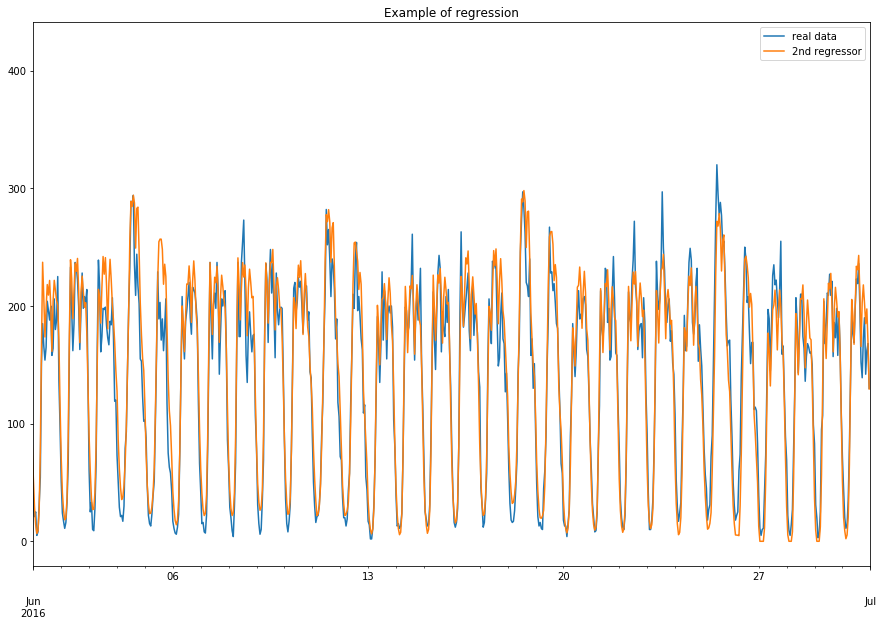

In [9]:
testSet2 = df2.query("region == '1076'")
plt.figure(figsize=[15,10])
testSet2.y.plot()
testSet2.regressor.plot()
plt.xlim(['06-2016','07-2016'])
plt.title('Example of regression')
plt.legend(['real data','2nd regressor'])

In [12]:
df3 = df2.loc['23:00:00 05-31-2016':'23:00:00 6-30-2016',['regressor','region']]
df3 = df2.loc['23:00:00 05-31-2016':'23:00:00 6-30-2016',['regressor','region']]
df3 = df3.assign(y1 = df3.regressor.shift(-1)).assign(y2 = df3.regressor.shift(-2)).assign(y3 = df3.regressor.shift(-3))
df3 = df3.assign(y4 = df3.regressor.shift(-4)).assign(y5 = df3.regressor.shift(-5)).assign(y6 = df3.regressor.shift(-6))
saveFile(df3,'w5-r2.csv')

In [13]:
df2 = df2.assign(sarimax1 = 0).assign(sarimax2 = 0).assign(sarimax3 = 0)
df2 = df2.assign(sarimax4 = 0).assign(sarimax5 = 0).assign(sarimax6 = 0)

In [18]:
sarimaxParams = np.load('sarimaxParams.npy').item()

for regName in regNames:
    print 'Learn SARIMAX', regName
    subSet = df2.query('region == @regName')
    
    # получить параметры SARIMAX моделе
    params = sarimaxParams.get(regName)
    try: 
        mSARIMA=sm.tsa.statespace.SARIMAX(subSet.loc[startTrain:endValidation,'y'],
                                          order=[params[0], 1, params[1]],
                                          seasonal_order=(params[2], 1, params[3], 24),
                                          exog = subSet.loc[startTrain:endValidation,'regressor'],
                                          enforce_invertibility = True).fit(disp=1);
    except Exception as inst:
        print type(inst)     
        print inst          

    # создаём новую модель, которую будет использовать для предсказания
    # Для чего такой финт ушами - не понимаю до сих пор
    try:
        model_fitted = sm.tsa.statespace.SARIMAX(subSet.y,
                                             order=[params[0], 1, params[1]],
                                             seasonal_order=(params[2], 1, params[3], 24),
                                             exog = subSet.regressor,
                                             enforce_invertibility = True).filter(mSARIMA.params)
    except Exception as inst:
        print 'Can not create the model'
        print inst
        continue
    
    else:

        # проходим по всему диапазону дат предсказаний
        print 'Make prediction'
        for firstLag in subSet.index:
            print firstLag
            lastLag = firstLag+datetime.timedelta(hours = 5)
            # prediction
            try:
                predicted_data = model_fitted.predict(firstLag, lastLag, dynamic=True, exog = subSet.loc[firstLag:lastLag,'regressor'])

                subSet.loc[firstLag,'sarimax1'] = predicted_data[0]
                subSet.loc[firstLag,'sarimax2'] = predicted_data[1]
                subSet.loc[firstLag,'sarimax3'] = predicted_data[2]
                subSet.loc[firstLag,'sarimax4'] = predicted_data[3]
                subSet.loc[firstLag,'sarimax5'] = predicted_data[4]
                subSet.loc[firstLag,'sarimax6'] = predicted_data[5]

            except Exception as inst:
                print 'Prediction error'
                print inst

        df2.loc[df2.region == regName,:] = subSet
        df2.to_pickle('sarimax_prediction.pcl')

Learn SARIMAX 1075
Make prediction
2014-01-01 00:00:00
2014-01-01 01:00:00
2014-01-01 02:00:00
2014-01-01 03:00:00
2014-01-01 04:00:00
2014-01-01 05:00:00
2014-01-01 06:00:00
2014-01-01 07:00:00
2014-01-01 08:00:00
2014-01-01 09:00:00
2014-01-01 10:00:00
2014-01-01 11:00:00
2014-01-01 12:00:00
2014-01-01 13:00:00
2014-01-01 14:00:00
2014-01-01 15:00:00
2014-01-01 16:00:00
2014-01-01 17:00:00
2014-01-01 18:00:00
2014-01-01 19:00:00
2014-01-01 20:00:00
2014-01-01 21:00:00
2014-01-01 22:00:00
2014-01-01 23:00:00
2014-01-02 00:00:00
2014-01-02 01:00:00
2014-01-02 02:00:00
2014-01-02 03:00:00
2014-01-02 04:00:00
2014-01-02 05:00:00
2014-01-02 06:00:00
2014-01-02 07:00:00
2014-01-02 08:00:00
2014-01-02 09:00:00
2014-01-02 10:00:00
2014-01-02 11:00:00
2014-01-02 12:00:00
2014-01-02 13:00:00
2014-01-02 14:00:00
2014-01-02 15:00:00
2014-01-02 16:00:00
2014-01-02 17:00:00
2014-01-02 18:00:00
2014-01-02 19:00:00
2014-01-02 20:00:00
2014-01-02 21:00:00
2014-01-02 22:00:00
2014-01-02 23:00:00
2014-

KeyboardInterrupt: 